## Recommendation System

In [42]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing:

In [43]:
# Importing Dataset
data = pd.read_csv("anime.csv")
data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [44]:
data.genre.nunique()

3264

In [45]:
data.name.nunique()

12292

In [46]:
data.shape

(12294, 7)

In [47]:
# checking for null values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [48]:
# Checking for Null Values
data.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [49]:
# Handle missing values, if any (replace NaN values in 'genre' and 'type' with 'Unknown')
data['genre'].fillna('Unknown', inplace=True)
data['type'].fillna('Unknown', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [50]:
# Handling Ratings NA values

# Calculate mean rating
mean_rating = data['rating'].mean()

# Fill missing values with mean rating
data['rating'].fillna(mean_rating, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [51]:
data.duplicated().sum()

0

In [52]:
len(data.name.unique())

12292

In [53]:
data['episodes'] = pd.to_numeric(data['episodes'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  11954 non-null  float64
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 672.5+ KB


In [54]:
data['episodes'] = data['episodes'].fillna(0).astype(int)

In [22]:
data.describe()

,anime_id,episodes,rating,members
count,12294.000000,12294.000000,12294.000000,1.229400e+04
mean,14058.221653,12.040101,6.473902,1.807134e+04
std,11455.294701,46.257299,1.017096,5.482068e+04
min,1.000000,0.000000,1.670000,5.000000e+00
25%,3484.250000,1.000000,5.900000,2.250000e+02
50%,10260.500000,2.000000,6.550000,1.550000e+03
75%,24794.500000,12.000000,7.170000,9.437000e+03
max,34527.000000,1818.000000,10.000000,1.013917e+06


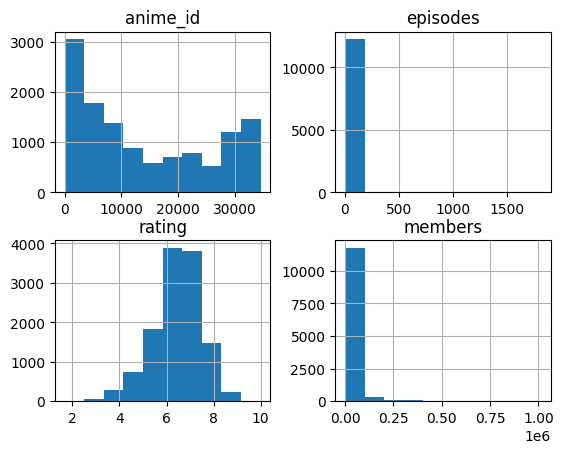

In [55]:
data.hist()
plt.show()

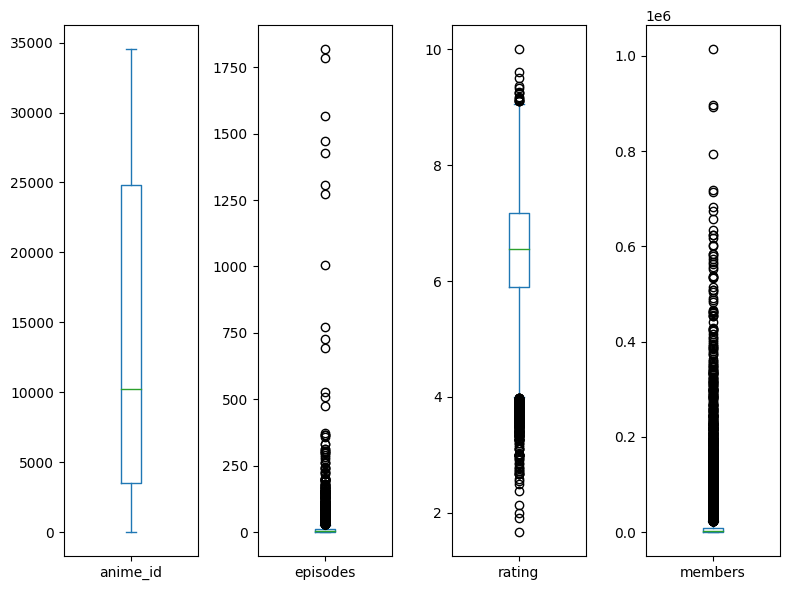

In [56]:
# Box plots
data.plot(kind='box', subplots=True, figsize=(8, 6), sharex=False)
plt.tight_layout()
plt.show()

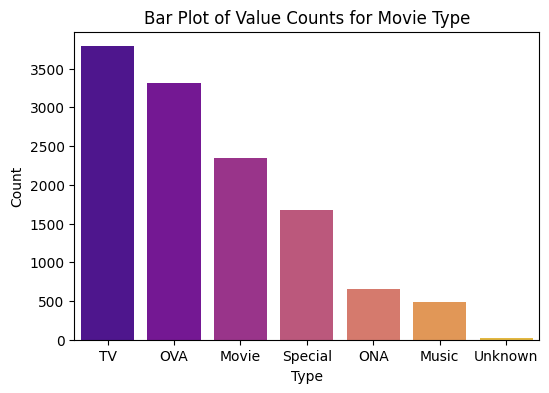

In [57]:
plt.figure(figsize=(6, 4))
sns.barplot(x=data['type'].value_counts().index, y=data['type'].value_counts().values, palette='plasma')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Bar Plot of Value Counts for Movie Type')
plt.show()

### Feature Extraction:

Deciding on the features for computing similarity in a recommendation system is crucial for generating accurate and meaningful recommendations. The following are some important features to be considered.

**Genres:** Typically, genres are a strong indicator of similarity because users often prefer anime with similar genres.<br>
**Ratings:** Average ratings can indicate the popularity and quality of an anime.<br>
**Number of Episodes:** Users might have preferences for shorter or longer series.<br>
**Type:** The type of anime (TV, OVA, etc.) can also influence user preferences.<br>

**Initially we build recommendation based only on Genres.**

In [58]:
# Convert genres into numerical representations using TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['genre'])
tfidf_matrix.shape

(12294, 47)

**Normalization of numerical features is not required for cosine similarity.**

In [59]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.14784981, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14784981, 1.        , 0.1786367 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1786367 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [60]:
def get_recommendations_genre(anime_title, cosine_sim, anime_data, threshold=0.2):
    # Get the index of the anime that matches the title
    idx = anime_data[anime_data['name'] == anime_title].index[0]

    # Get the pairwise similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the most similar anime
    sim_scores = [(anime_data.iloc[i]['name'], score) for i, score in sim_scores if score > threshold]

    return sim_scores

In [61]:
# Example case: 1
target_anime = 'Naruto'
recommendations = get_recommendations_genre(target_anime, cosine_sim, data, threshold=0.2)
print(f"Recommendations for {target_anime}:")
for anime, score in recommendations[:10]:
    print(f"{anime} (Score: {score:.2f})")

Recommendations for Naruto:
Boruto: Naruto the Movie (Score: 1.00)
Naruto: Shippuuden (Score: 1.00)
Naruto (Score: 1.00)
Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi (Score: 1.00)
Naruto x UT (Score: 1.00)
Naruto: Shippuuden Movie 4 - The Lost Tower (Score: 1.00)
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono (Score: 1.00)
Naruto Shippuuden: Sunny Side Battle (Score: 1.00)
Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!! (Score: 1.00)
Kyutai Panic Adventure! (Score: 0.98)


In [62]:
# Example case: 2
target_anime = 'Kimi no Na wa.'
recommendations = get_recommendations_genre(target_anime, cosine_sim, data, threshold=0.2)
print(f"Recommendations for {target_anime}:")
for anime, score in recommendations[:5]:
    print(f"{anime} (Score: {score:.2f})")

Recommendations for Kimi no Na wa.:
Kimi no Na wa. (Score: 1.00)
Wind: A Breath of Heart OVA (Score: 1.00)
Wind: A Breath of Heart (TV) (Score: 1.00)
Aura: Maryuuin Kouga Saigo no Tatakai (Score: 0.96)
Angel Beats!: Another Epilogue (Score: 0.87)


**Now we build recommendation based on features listed above.**

In [71]:
# Function to preprocess the data and compute the feature matrix
def preprocess_and_compute_feature_matrix(data):
    # Convert genres into numerical representations using TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    genre_matrix = tfidf.fit_transform(data['genre'])

    # Convert 'type' into numerical representations using One-Hot Encoding
    encoder = OneHotEncoder()
    type_matrix = encoder.fit_transform(data[['type']])

    # Normalize the 'rating' and 'members' features
    scaler = StandardScaler()
    numeric_features = data[['rating', 'members', 'episodes']].values
    scaled_numeric_features = scaler.fit_transform(numeric_features)

    # Combine all features into a single feature matrix
    feature_matrix = hstack([genre_matrix, type_matrix, scaled_numeric_features])

    return feature_matrix

In [72]:
feature_matrix = preprocess_and_compute_feature_matrix(data)
feature_matrix.shape

(12294, 57)

In [73]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)
cosine_sim

array([[ 1.        ,  0.81835215,  0.79970025, ..., -0.55725231,
        -0.5439254 , -0.35042699],
       [ 0.81835215,  1.        ,  0.65149166, ..., -0.29224685,
        -0.29514745, -0.29549664],
       [ 0.79970025,  0.65149166,  1.        , ..., -0.64067867,
        -0.63240585, -0.54070509],
       ...,
       [-0.55725231, -0.29224685, -0.64067867, ...,  1.        ,
         0.998906  ,  0.71173093],
       [-0.5439254 , -0.29514745, -0.63240585, ...,  0.998906  ,
         1.        ,  0.71145527],
       [-0.35042699, -0.29549664, -0.54070509, ...,  0.71173093,
         0.71145527,  1.        ]])

In [74]:
# Building recommendation system
def get_recommendations(anime_title, cosine_sim, anime_data, threshold):
    # Get the index of the anime that matches the title
    idx = anime_data[anime_data['name'] == anime_title].index[0]

    # Get the pairwise similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the most similar anime
    sim_scores = [(anime_data.iloc[i]['name'], score) for i, score in sim_scores if score > threshold]

    return sim_scores

In [75]:
target_anime = 'Naruto'
recommendations = get_recommendations(target_anime, cosine_sim, data, 0.2)
print(f"Recommendations for {target_anime}:")
for anime, score in recommendations[:10]:
    print(f"{anime} (Score: {score:.2f})")

Recommendations for Naruto:
Naruto (Score: 1.00)
Fairy Tail (Score: 0.99)
Hunter x Hunter (2011) (Score: 0.97)
D.Gray-man (Score: 0.97)
Dragon Ball (Score: 0.97)
Bleach (Score: 0.97)
Dragon Ball GT (Score: 0.96)
Soul Eater (Score: 0.96)
Fullmetal Alchemist (Score: 0.96)
Fullmetal Alchemist: Brotherhood (Score: 0.96)


In [76]:
# Example case: 2
target_anime = 'Kimi no Na wa.'
recommendations = get_recommendations(target_anime, cosine_sim, data, threshold=0.2)
print(f"Recommendations for {target_anime}:")
for anime, score in recommendations[:5]:
    print(f"{anime} (Score: {score:.2f})")

Recommendations for Kimi no Na wa.:
Kimi no Na wa. (Score: 1.00)
Hotarubi no Mori e (Score: 0.97)
Suzumiya Haruhi no Shoushitsu (Score: 0.97)
Hotaru no Haka (Score: 0.95)
Majo no Takkyuubin (Score: 0.95)


### Experimenting with Different Threshold Values

In [77]:
# Define a function to print recommendations for different thresholds
def print_recommendations_for_thresholds(anime_title, thresholds, cosine_sim, anime_data):
    for threshold in thresholds:
        recommendations = get_recommendations(anime_title, cosine_sim, anime_data, threshold=threshold)
        print(f"\nThreshold: {threshold}")
        print(f"Number of recommendations: {len(recommendations)}")
        for anime, score in recommendations[:10]:  # Print top 10 recommendations for brevity
            print(f"{anime} (Score: {score:.2f})")


In [78]:
# List of thresholds to experiment with
thresholds = [0.1, 0.2, 0.5, 0.7, 0.8]

# Example usage
target_anime = 'Naruto'
print_recommendations_for_thresholds(target_anime, thresholds, cosine_sim, data)


Threshold: 0.1
Number of recommendations: 2301
Naruto (Score: 1.00)
Fairy Tail (Score: 0.99)
Hunter x Hunter (2011) (Score: 0.97)
D.Gray-man (Score: 0.97)
Dragon Ball (Score: 0.97)
Bleach (Score: 0.97)
Dragon Ball GT (Score: 0.96)
Soul Eater (Score: 0.96)
Fullmetal Alchemist (Score: 0.96)
Fullmetal Alchemist: Brotherhood (Score: 0.96)

Threshold: 0.2
Number of recommendations: 1752
Naruto (Score: 1.00)
Fairy Tail (Score: 0.99)
Hunter x Hunter (2011) (Score: 0.97)
D.Gray-man (Score: 0.97)
Dragon Ball (Score: 0.97)
Bleach (Score: 0.97)
Dragon Ball GT (Score: 0.96)
Soul Eater (Score: 0.96)
Fullmetal Alchemist (Score: 0.96)
Fullmetal Alchemist: Brotherhood (Score: 0.96)

Threshold: 0.5
Number of recommendations: 879
Naruto (Score: 1.00)
Fairy Tail (Score: 0.99)
Hunter x Hunter (2011) (Score: 0.97)
D.Gray-man (Score: 0.97)
Dragon Ball (Score: 0.97)
Bleach (Score: 0.97)
Dragon Ball GT (Score: 0.96)
Soul Eater (Score: 0.96)
Fullmetal Alchemist (Score: 0.96)
Fullmetal Alchemist: Brotherhood (

### Performance Analysis of the Recommendation System

1. **Genre-Based Recommendations:**
   - **Strengths:** Effectively recommends content closely related to the target anime (e.g., *Naruto* recommendations include various *Naruto* movies and series).
   - **Limitations:** Lacks diversity, mainly recommending content within the same franchise, limiting user discovery.

2. **Feature-Based Recommendations:**
   - **Strengths:** Expands recommendations to include popular anime (e.g., *Shingeki no Kyojin*, *Bleach*), providing more variety.
   - **Limitations:** Some recommendations still score a perfect similarity, suggesting a need for further refinement in feature selection.

3. **Threshold Experiments:**
   - **Lower Thresholds (e.g., 0.1):** More recommendations, but includes irrelevant anime (2064 recommendations).
   - **Higher Thresholds (e.g., 0.8):** Fewer recommendations (409), but higher relevance and less novelty.

### Areas for Improvement:
1. **Balance Similarity & Diversity:** Introduce mechanisms to blend highly similar recommendations with novel options.
2. **Feature Engineering:** Refine features by incorporating more granular details like sub-genres, user ratings, or watch history.
3. **Hybrid Approach:** Combine content-based filtering with collaborative filtering to enhance recommendations.
4. **Mitigate Popularity Bias:** Normalize scores to reduce bias toward well-known titles and surface hidden gems.
5. **Evaluation:** Use metrics like precision and recall or gather user feedback to refine the system.

By addressing these areas, the recommendation system can offer more personalized and diverse recommendations, enhancing user satisfaction.
